In [2]:
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import gym
from environment import Environment

Step 1：Prepare data (batch)

Step 2：Neural Network 

Step 3: Define loss function and optimizer

Step 4：Train the network

Step 5：GPU

### Step 1. Prepare Data
* Tensor
* Shape

In [3]:
# Prepare Data
"""Generally, when you have to deal with image, text, audio or video data, 
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color 
images of 32x32 pixels in size."""


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
print('original dtype:',type(trainset.data))
print('original shape:',trainset.data.shape)

Files already downloaded and verified
original dtype: <class 'numpy.ndarray'>
original shape: (50000, 32, 32, 3)


In [4]:
def batch(data,batch_size):
    minibatch = random.sample(data, batch_size)
    minibatch = np.array(minibatch).transpose(0,3,1,2) # (0,1,2,3) becomes (0,3,1,2) 
#     minibatch = torch.tensor(minibatch/ 255.0)
    return minibatch

In [5]:
minibatch = batch(list(trainset.data),32)
# print(minibatch[1]) #(imageNum, row, col, channel)
print(minibatch.shape)
print(minibatch.dtype)

(32, 3, 32, 32)
uint8


[[ 142.  142.  142. ...,  142.  142.  142.]
 [ 142.  142.  142. ...,  142.  142.  142.]
 [ 142.  142.  142. ...,  142.  142.  142.]
 ..., 
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]]
shape: (170, 150)
dtype: float64


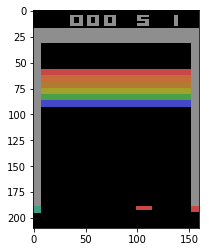

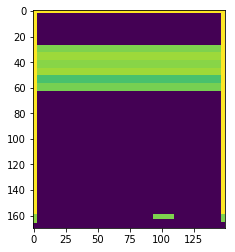

In [38]:
# what does env.reset() look like?
env = Environment('BreakoutNoFrameskip-v4', "", atari_wrapper=False, test=False)

# action_space = 4
# env = <TimeLimit<AtariEnv<BreakoutNoFrameskip-v4>>
# get_action_space() = Discrete(4)
# get_observation_space() = Box(210, 160, 3) - Image (row, col, channel)
# observation_space = Box(210, 160, 3)
# reset() = image(210,160,3) uint8
# seed() = ??
# env.reset()
# env.render()

frame = env.reset()
plt.imshow(frame)
plt.figure()
frame = frame[30:200, 5:155,:] #Image cropping to speed up
frame = np.mean(frame, axis=2)
plt.imshow(frame)
print(frame)
print("shape:",frame.shape)
print("dtype:",frame.dtype)

### Step 2. Neural Network
* init()
  * layers
* forward
  * activation function + combine layers

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        """
        """
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
net = Net()

### Step 3. Define loss and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Step 4. Train the network

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        ####################################################
        # tensor
        # batch_size, channel, H, W
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ####################################################
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.179
[1,  4000] loss: 1.839
[1,  6000] loss: 1.668
[1,  8000] loss: 1.576


KeyboardInterrupt: 

### Step 5. GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [13]:
# Assign network to cuda
net = Net().to(device)

In [14]:


# Assign input and output to cuda
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        ####################################################
        # tensor
        # batch_size, channel, H, W
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ####################################################
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.304
[1,  6000] loss: 2.305
[1,  8000] loss: 2.303
[1, 10000] loss: 2.304
[1, 12000] loss: 2.303
[2,  2000] loss: 2.304


KeyboardInterrupt: 